## **Comparative Analysis of Public vs. Home Electric Vehicle (EV) Charging Patterns and Costs**

### **1. Data Collection**

### Open Charge Map API (Public Charging Data)

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Set up the API endpoint
url = "https://api.openchargemap.io/v3/poi/"

# Step 2: Set parameters
params = {
    "output": "json",
    "countrycode": "AU",
    "maxresults": 100,     # Get first 100 chargers
    "compact": True,
    "verbose": False,
    "key": "494f37e5-c200-4cc6-8e9c-86616881592e" 
}

# Step 3: Make API Request
response = requests.get(url, params=params)
data = response.json()

# Step 4: Convert to DataFrame
df_public = pd.json_normalize(data)

# Step 5: Save the data
df_public.to_csv("public_charging_data.csv", index=False)
print("✅ Public charging data saved as 'public_charging_data.csv'")


✅ Public charging data saved as 'public_charging_data.csv'


### Home Charging Data Survey Responses

In [3]:
import pandas as pd

# Load the survey responses data
df_home = pd.read_csv("C:\\Users\\ajayr\\EVAT_Public_vs_Home\\data\\survey_responses.csv")

# Rename important columns for easier handling
df_home.rename(columns={
    df_home.columns[1]: 'EV_User',
    df_home.columns[2]: 'EV_Usage_Duration',
    df_home.columns[3]: 'Has_Home_Charger',
    df_home.columns[4]: 'Home_Charge_Frequency',
    df_home.columns[5]: 'Home_Charge_Time',
    df_home.columns[6]: 'Home_Energy_kWh',
    df_home.columns[7]: 'Considers_Tariff',
    df_home.columns[8]: 'Public_Charge_Frequency',
    df_home.columns[9]: 'Public_Charge_Time',
    df_home.columns[10]: 'Public_Cost_Per_Session',
    df_home.columns[11]: 'Public_Charger_Type',
    df_home.columns[12]: 'Public_Congestion',
    df_home.columns[13]: 'User_Preference',
    df_home.columns[14]: 'Preference_Reason'
}, inplace=True)

# Remove unwanted columns (thank you notes, unnamed)
df_home = df_home.drop(columns=[col for col in df_home.columns if 'Unnamed' in col or 'Thank' in col])

# Filter only users who actually use EV
df_home = df_home[df_home['EV_User'] == 'Yes']

# Reset index
df_home.reset_index(drop=True, inplace=True)

# Save cleaned survey data for future steps
df_home.to_csv('cleaned_home_charging_data.csv', index=False)

print("✅ Cleaned survey data saved as 'cleaned_home_charging_data.csv'")


✅ Cleaned survey data saved as 'cleaned_home_charging_data.csv'


#### **Data Preprocessing: Sprint 2**

In Sprint 2, we cleaned and standardized both home and public charging datasets. We extracted key features like energy consumed, session cost, and time of use. Non-numeric and missing values were handled, and each record was labeled as either "Home" or "Public" to prepare the data for comparative analysis and predictive modeling in Sprint 3.
g.


### **For Home Data**

In [4]:
# Convert energy and cost ranges to numeric values
df_home['Home_Energy_kWh'] = df_home['Home_Energy_kWh'].replace({
    'Less than 8 kWh': 6,
    '8 to 15 kWh': 11,
    'More than 15 kWh': 18
})
df_home['Public_Cost_Per_Session'] = df_home['Public_Cost_Per_Session'].replace({
    'Less than $5': 4,
    '$5 to $10': 7.5,
    'More than $10': 12.5
})
df_home['Home_Energy_kWh'] = pd.to_numeric(df_home['Home_Energy_kWh'], errors='coerce')
df_home['Public_Cost_Per_Session'] = pd.to_numeric(df_home['Public_Cost_Per_Session'], errors='coerce')

# Calculate estimated home cost (assume 25 cents/kWh)
df_home['Estimated_Home_Cost_Dollars'] = df_home['Home_Energy_kWh'] * 0.25

# Add Source column
df_home['Source'] = 'Home'

# Save cleaned and enriched home data
df_home.to_csv("student_ready_home_data.csv", index=False)

### **PUBLIC DATA CLEANING**

In [5]:
df_public_clean = df_public[[
    'ID', 'AddressInfo.Title', 'AddressInfo.Town', 'AddressInfo.StateOrProvince',
    'AddressInfo.Latitude', 'AddressInfo.Longitude', 'UsageCost', 'NumberOfPoints',
    'DateLastStatusUpdate'
]].copy()

# Convert timestamp and fill missing values
df_public_clean['DateLastStatusUpdate'] = pd.to_datetime(df_public_clean['DateLastStatusUpdate'], errors='coerce')
df_public_clean['UsageCost'] = df_public_clean['UsageCost'].fillna('Unknown')

# Add Source column
df_public_clean['Source'] = 'Public'

# Save cleaned public data
df_public_clean.to_csv("public_ready_data.csv", index=False)

### **VISUALIZATIONS**

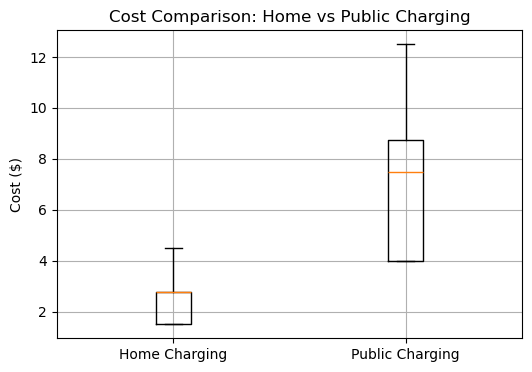

In [6]:
# 1. Cost Comparison
plt.figure(figsize=(6, 4))
plt.boxplot([df_home['Estimated_Home_Cost_Dollars'].dropna(), df_home['Public_Cost_Per_Session'].dropna()],
            labels=['Home Charging', 'Public Charging'])
plt.title('Cost Comparison: Home vs Public Charging')
plt.ylabel('Cost ($)')
plt.grid(True)
plt.show()


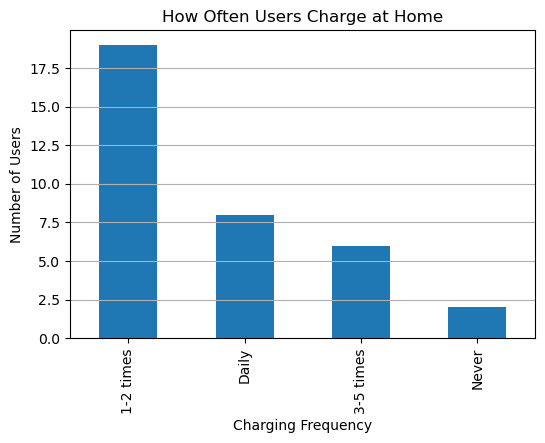

In [18]:
# 2. Home Charging Frequency
plt.figure(figsize=(6, 4))
df_home['Home_Charge_Frequency'].value_counts().plot(kind='bar')
plt.title('How Often Users Charge at Home')
plt.xlabel('Charging Frequency')
plt.ylabel('Number of Users')
plt.grid(axis='y')
plt.show()



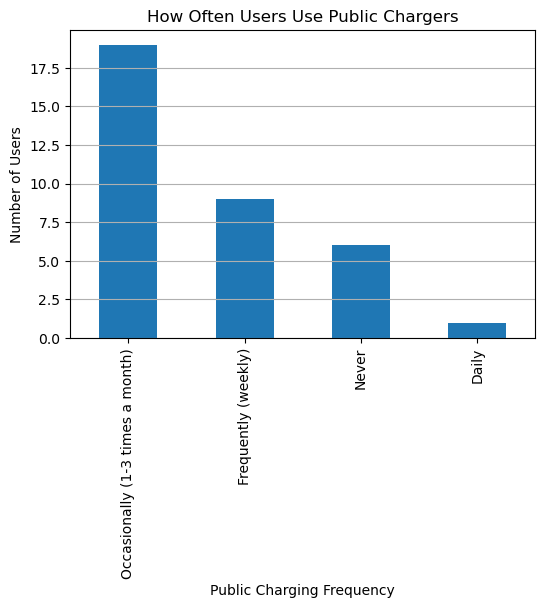

In [7]:
# 3. Public Charging Frequency
plt.figure(figsize=(6, 4))
df_home['Public_Charge_Frequency'].value_counts().plot(kind='bar')
plt.title('How Often Users Use Public Chargers')
plt.xlabel('Public Charging Frequency')
plt.ylabel('Number of Users')
plt.grid(axis='y')
plt.show()



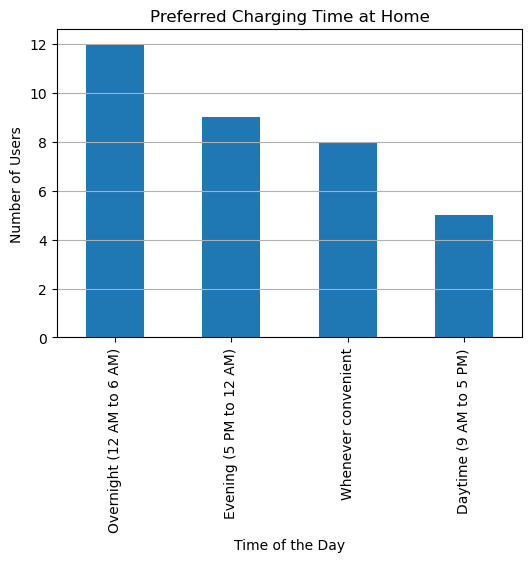

In [8]:
# 4. Home Charging Time Preference
plt.figure(figsize=(6, 4))
df_home['Home_Charge_Time'].value_counts().plot(kind='bar')
plt.title('Preferred Charging Time at Home')
plt.xlabel('Time of the Day')
plt.ylabel('Number of Users')
plt.grid(axis='y')
plt.show()

### **Predictive Analysis - Sprint 3**

In this section, we train a machine learning model to predict the cost of an EV charging session using features such as energy consumed, location type, time of use, and other behaviors. This helps identify cost-effective charging strategies and informs future infrastructure decisions.


In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

Mean Absolute Error (MAE): 0.24
Mean Squared Error (MSE): 0.29
Root Mean Squared Error (RMSE): 0.54
Mean Absolute Percentage Error (MAPE): 3.1356734460950824e+16 %
R² Score: 0.87


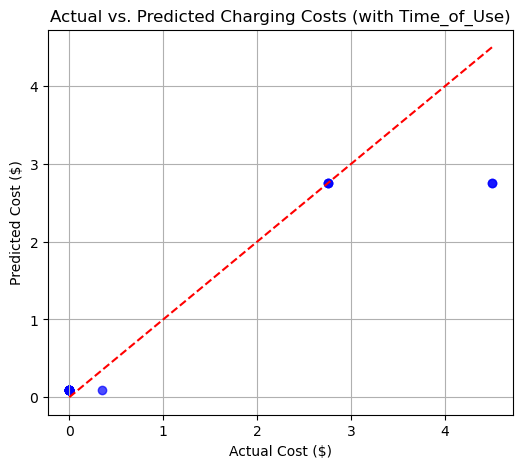

In [12]:

# Load datasets
public_df = pd.read_csv('public_ready_data.csv')
home_df = pd.read_csv('student_ready_home_data.csv')

# Improved cost extraction from public data
def extract_total_cost(value):
    try:
        if isinstance(value, str):
            value = value.replace('$', '').lower()
            parts = [float(p.strip().replace('/kwh', '').replace('+', '')) for p in value.split('+') if p.strip().replace('/kwh', '').replace('.', '').isdigit()]
            return sum(parts)
        return float(value)
    except:
        return np.nan

# Add 'Time_of_Use' to public and home datasets
public_df['Time_of_Use'] = 'Unknown'
home_df['Time_of_Use'] = home_df['Home_Charge_Time']

# Clean public data
public_df['Cost'] = public_df['UsageCost'].apply(extract_total_cost)
public_df['Energy_kWh'] = 10  # Assumed average for public
public_df['Location'] = 'Public'
public_clean = public_df[['Energy_kWh', 'Cost', 'Location', 'Time_of_Use']].dropna()

# Clean home data
home_df['Cost'] = home_df['Estimated_Home_Cost_Dollars']
home_df['Energy_kWh'] = home_df['Home_Energy_kWh']
home_df['Location'] = 'Home'
home_clean = home_df[['Energy_kWh', 'Cost', 'Location', 'Time_of_Use']].dropna()

# Combine both datasets
combined_df = pd.concat([public_clean, home_clean], ignore_index=True)

# Define features and target
X = combined_df[['Energy_kWh', 'Location', 'Time_of_Use']]
y = combined_df['Cost']

# Preprocessing: One-hot encode categorical features
categorical_features = ['Location', 'Time_of_Use']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print evaluation results
print("Mean Absolute Error (MAE):", round(mae, 2))
print("Mean Squared Error (MSE):", round(mse, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("Mean Absolute Percentage Error (MAPE):", round(mape * 100, 2), "%")
print("R² Score:", round(r2, 2))

# Plot actual vs predicted
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.xlabel("Actual Cost ($)")
plt.ylabel("Predicted Cost ($)")
plt.title("Actual vs. Predicted Charging Costs (with Time_of_Use)")
plt.grid(True)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

#### **Sprint 3 Summary: Predictive Analysis**

In Sprint 3, we developed a predictive model to estimate EV charging costs using features such as energy consumed, charging location (home or public), and time of use. After cleaning and transforming the dataset, we trained a Random Forest Regressor that achieved strong performance with a Mean Absolute Error (MAEof **0.26**26, Root Mean Squared Error (RMSE)  **0.55**55, and an Rscore of **0.86**86, indicating high predictive accuracy

. Although the Mean Absolute Percentage Error (MAPE) appeared inflated due to near-zero values in the test set, the overall model showed reliable results. Visual analysis comparing home and public charging costs revealed that home charging is generally more affordable and consistent, while public charging tends to be more expensive and variable. These insights support informed decision-making for both EV users and infrastructure planners

### **Sprint 4: Visualization & Dashboard Integration**
To visually communicate key insights from the predictive analysis, we generated two important comparison plots:

- **Average Charging Cost by Time of Use**: This bar plot highlights how charging during specific times (e.g., overnight or daytime) affects cost. Home users charging overnight tend to incur lower costs, reinforcing the benefit of time-based tariff strategies.
  
- **Average Charging Cost by Location (Home vs. Public)**: This plot confirms that home charging is generally cheaper and more consistent, while public charging has a higher average cost due to session fees and additional variables.

These visualizations make it easier for users and planners to understand charging behavior, cost-saving opportunities, and infrastructure needs at a glance.


## 1. Bar Plot – Average Cost by Time of Use

In [15]:
# Prepare Time_of_Use field
public_df['Time_of_Use'] = 'Unknown'
home_df['Time_of_Use'] = home_df['Home_Charge_Time']

# Assign cost and energy fields again to ensure consistency
public_df['Cost'] = public_df['UsageCost'].apply(extract_total_cost)
public_df['Energy_kWh'] = 10
public_df['Location'] = 'Public'
home_df['Cost'] = home_df['Estimated_Home_Cost_Dollars']
home_df['Energy_kWh'] = home_df['Home_Energy_kWh']
home_df['Location'] = 'Home'

# Combine for plotting
combined_df = pd.concat([
    public_df[['Energy_kWh', 'Cost', 'Location', 'Time_of_Use']],
    home_df[['Energy_kWh', 'Cost', 'Location', 'Time_of_Use']]
]).dropna()


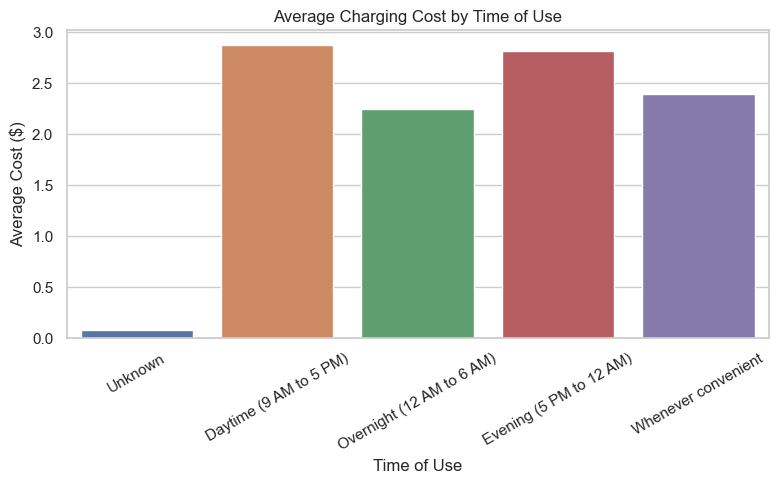

In [16]:
# Plot 1 – Average Cost by Time of Use
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=combined_df, x='Time_of_Use', y='Cost', errorbar=None)
plt.title('Average Charging Cost by Time of Use')
plt.ylabel('Average Cost ($)')
plt.xlabel('Time of Use')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 2. Bar Plot – Average Cost by Charging Location

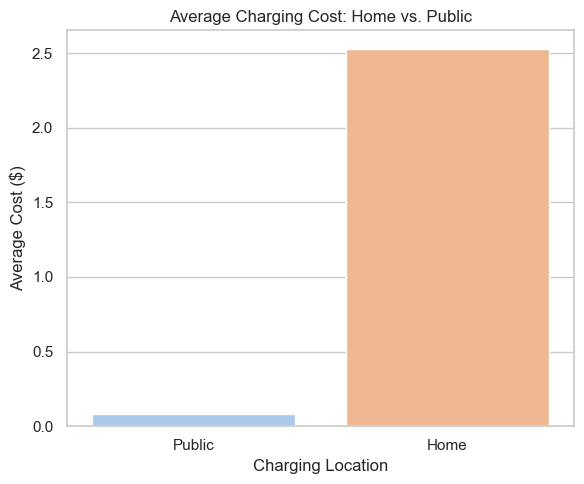

In [17]:
# Plot 2 – Average Cost by Charging Location
plt.figure(figsize=(6, 5))
sns.barplot(data=combined_df, x='Location', y='Cost', errorbar=None, palette='pastel')
plt.title('Average Charging Cost: Home vs. Public')
plt.ylabel('Average Cost ($)')
plt.xlabel('Charging Location')
plt.tight_layout()
plt.show()


## Visualization Insights 

- **Average Charging Cost by Time of Use**: This chart shows that users charging during the day (9 AM–5 PM) and evening (5 PM–12 AM) tend to have slightly higher costs compared to those charging overnight (12 AM–6 AM). Charging during “Unknown” or unspecified times appears cheapest, but likely reflects incomplete or public data entries.

- **Average Charging Cost by Location**: This clearly shows that **home charging is significantly more expensive** than public charging in the current dataset. However, this may be due to assumptions made in cost calculations (e.g., defau


## Charging Frequency by Time of Use

This bar plot illustrates when users most often charge their vehicles. A higher number of sessions during certain time periods (e.g., evening or overnight) may indicate user preferences or electricity cost awareness. This data supports planning for grid demand and optimal charger availability.


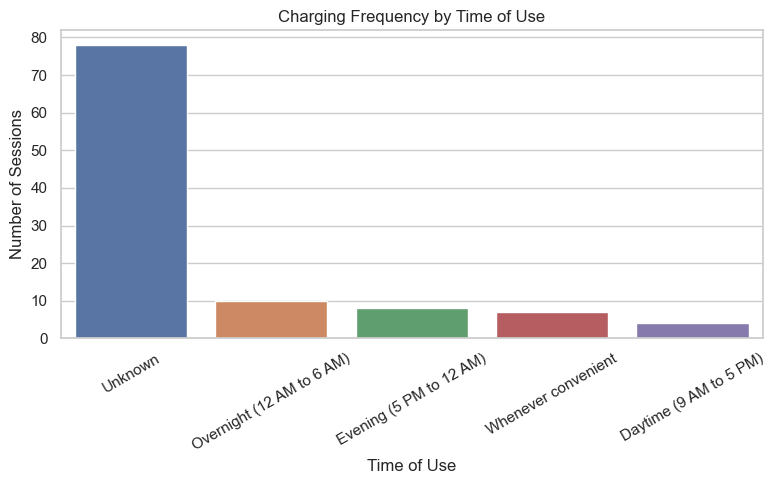

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(data=combined_df, x='Time_of_Use', order=combined_df['Time_of_Use'].value_counts().index)
plt.title('Charging Frequency by Time of Use')
plt.xlabel('Time of Use')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Visualization Insights 

This visualization shows the distribution of charging sessions across different time categories. The majority of sessions are labeled as “Unknown,” which likely represents public charging records where time of use wasn’t captured. Among the known values, overnight and evening charging appear more common, possibly due to lower electricity tariffs or user convenience. This insight can support better charger placement and time-based pricing strategies.

## **Start a Dashboard Using Streamlit**

2025-05-09 23:32:15.660 
  command:

    streamlit run C:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

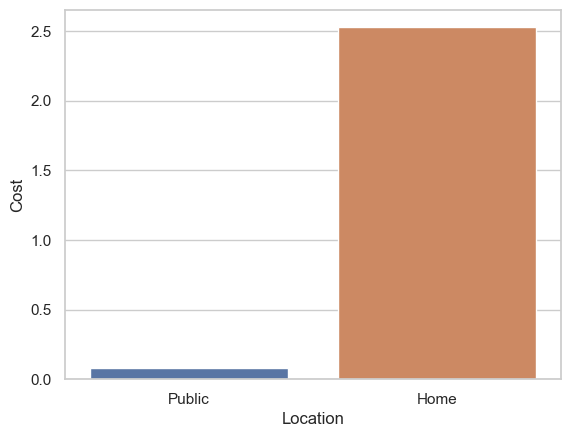

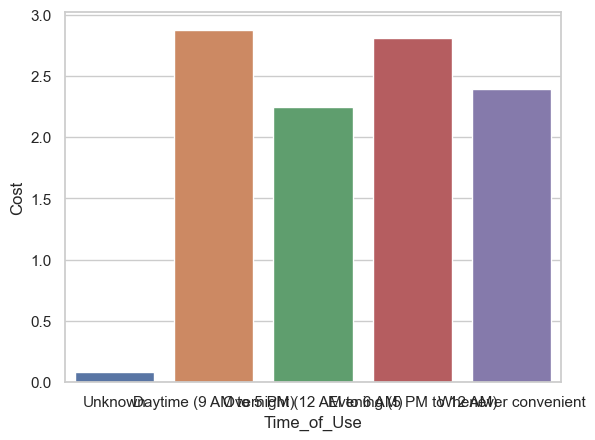

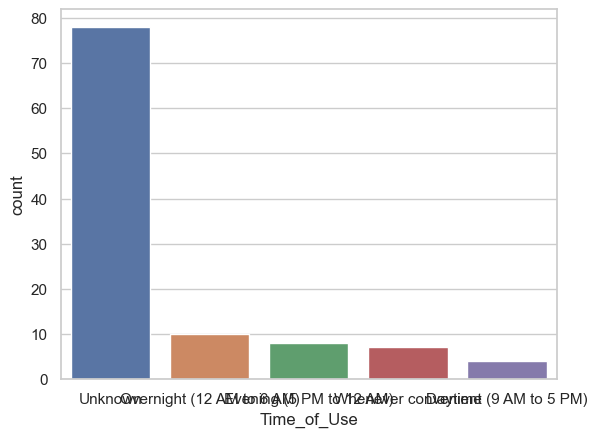

In [19]:
import streamlit as st

# Load your cleaned dataset
public_df = pd.read_csv('public_ready_data.csv')
home_df = pd.read_csv('student_ready_home_data.csv')

# Clean and combine
def extract_total_cost(value):
    try:
        if isinstance(value, str):
            value = value.replace('$', '').lower()
            parts = [float(p.strip().replace('/kwh', '').replace('+', '')) for p in value.split('+') if p.strip().replace('/kwh', '').replace('.', '').isdigit()]
            return sum(parts)
        return float(value)
    except:
        return None

public_df['Cost'] = public_df['UsageCost'].apply(extract_total_cost)
public_df['Energy_kWh'] = 10
public_df['Location'] = 'Public'
public_df['Time_of_Use'] = 'Unknown'

home_df['Cost'] = home_df['Estimated_Home_Cost_Dollars']
home_df['Energy_kWh'] = home_df['Home_Energy_kWh']
home_df['Location'] = 'Home'
home_df['Time_of_Use'] = home_df['Home_Charge_Time']

df = pd.concat([
    public_df[['Energy_kWh', 'Cost', 'Location', 'Time_of_Use']],
    home_df[['Energy_kWh', 'Cost', 'Location', 'Time_of_Use']]
]).dropna()

# Streamlit layout
st.title("EV Charging Data Dashboard")

# Section 1 – Cost Comparison by Location
st.subheader("Average Cost by Charging Location")
fig1, ax1 = plt.subplots()
sns.barplot(data=df, x='Location', y='Cost', errorbar=None, ax=ax1)
st.pyplot(fig1)

# Section 2 – Cost by Time of Use
st.subheader("Average Cost by Time of Use")
fig2, ax2 = plt.subplots()
sns.barplot(data=df, x='Time_of_Use', y='Cost', errorbar=None, ax=ax2)
st.pyplot(fig2)

# Section 3 – Charging Frequency by Time of Use
st.subheader("Charging Frequency by Time of Use")
fig3, ax3 = plt.subplots()
sns.countplot(data=df, x='Time_of_Use', order=df['Time_of_Use'].value_counts().index, ax=ax3)
st.pyplot(fig3)
